# 기업 평가 모델 및 성장 가능성 예측기 만들기 프로젝트

저희는 기업의 여러 요소를 수치화시켜 기업에 대한 점수를 매기는 기업 평가 모델을 만들고, 기업의 비재무적인 요소를 토대로 성장이 기대되는 기업을 알 수 있는 모델을 만드는 프로젝트를 진행하였습니다.

기업 평가 모델에 사용되는 요소는 다음과 같습니다.
1. 기업의 재무제표를 이용한 재무점수(재무적 요소)
2. 기업의 기술력(R&D과제, 특허 등)점수(비재무적 요소)
3. 기업의 평판점수(취업포탈리뷰 활용)(비재무적 요소)

이 3가지 점수를 더해서 기업 평가 점수를 통해 기업을 평가할 수 있습니다.

기업 성장 예측기에 사용되는 요소는 다음과 같습니다.
1. 매출 대비 기업의 기술력이 좋은 경우, 향후 매출이 늘 것으로 예상되어 성장 가능성이 높다고 가정
2. 현재 손실을 버틸 수 있는 자기자본이 어느 정도 보유된 기업
3. 절대적으로 기술가치가 상위권인 기업

이 3가지 요소를 통해 성장 가능성이 높은 기업들을 예측할 수 있습니다.

## 모듈 임포트

In [1]:
##데이터 전처리를 위한 pandas, numpy 라이브러리
import pandas as pd
import numpy as np
import warnings

##회귀모델 설계를 위한 sklearn, xgboost라이브러리
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

##시각화를 위한 matplotlib, seaborn 라이브러리
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

##토큰화를 위한 ekonlpy 라이브러리
from ekonlpy.tag import Mecab
from ekonlpy.sentiment import MPKO
from ekonlpy.sentiment import MPCK

##LDA를 위한 gensim 라이브러리
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

##백분위점수화를 위한 scipy 라이브러리
import scipy.stats as stats
# 경고 메시지를 무시하고자 할 때
warnings.filterwarnings("ignore")

## 1. 재무제표를 통한 재무점수 모델 만들기

저희는 머신러닝을 이용하여 재무점수 모델을 만들 것입니다. 신용등급정보를 정답레이블로 주고, 신용평가기관에서 신용평가모델에 대해 공개한 정보를 바탕으로 input에 들어갈 재무요소 feature들을 선정한 뒤, 회귀모델을 사용하여 지도학습을 진행할 것입니다.

### 1. 데이터 불러오기 및 데이터프레임 전처리

In [2]:
#기업 재무데이터 불러오기
finance = pd.read_csv("./재무제표정보_train.csv")
credit_rate = pd.read_csv("./신용등급정보_train.csv")

In [3]:
pivot_df = finance.pivot_table(index=['BusinessNum', 'stYear'], columns='accNm', values='acctAmt', aggfunc='first')
pivot_df = pivot_df.reset_index()
pivot_df

accNm,BusinessNum,stYear,노무비,당기순이익(손실),당좌부채(당좌차월),당좌자산,대손상각비,매출 증가율,매출액,매출원가,...,자본총계,자산총계,재고자산,제조경비,제조원가,차입금,총자산,총자산 증가율,투자자산,판매비와관리비
0,1010109319,2017.0,NaN,16161.0,NaN,1581.0,NaN,-1.023700e+01,197691.0,150702.0,...,-8404.0,4039.0,2458.0,NaN,NaN,0.0,4039.0,-5.038700e+01,NaN,33279.0
1,1010109319,2018.0,NaN,16528.0,NaN,912.0,NaN,-3.533000e+00,190706.0,133600.0,...,-23876.0,3080.0,2168.0,NaN,NaN,0.0,3080.0,-2.374400e+01,NaN,43077.0
2,1010109319,2019.0,NaN,15587.0,NaN,739.0,NaN,-6.400000e+00,178547.0,119689.0,...,-289.0,1893.0,1154.0,NaN,NaN,NaN,1893.0,-3.850000e+01,NaN,45903.0
3,1010204456,2017.0,NaN,81249.0,NaN,767959.0,NaN,1.934000e+01,948251.0,640197.0,...,81681.0,855215.0,NaN,NaN,NaN,764845.0,855215.0,-9.191000e+00,NaN,239192.0
4,1010204456,2018.0,NaN,100990.0,NaN,703415.0,NaN,1.312200e+01,1072681.0,651119.0,...,118671.0,959551.0,NaN,NaN,NaN,826940.0,959551.0,1.220000e+01,NaN,333335.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31332,8998803795,2017.0,NaN,-16643.0,NaN,90288.0,NaN,1.000000e+12,NaN,NaN,...,83357.0,90288.0,NaN,NaN,NaN,0.0,90288.0,1.000000e+12,NaN,16647.0
31333,8998803795,2018.0,NaN,-350557.0,NaN,2535306.0,NaN,1.000000e+12,148000.0,NaN,...,2632806.0,2656152.0,NaN,NaN,NaN,0.0,2656152.0,2.841866e+03,56190.0,547853.0
31334,8998803795,2019.0,NaN,-872519.0,NaN,4640985.0,NaN,3.972000e+02,735882.0,NaN,...,4760251.0,4888331.0,NaN,NaN,NaN,NaN,4888331.0,8.400000e+01,56190.0,1729077.0
31335,8998803795,2020.0,NaN,-746929.0,NaN,3881007.0,NaN,3.744900e+01,1011463.0,NaN,...,4013322.0,4150520.0,NaN,NaN,NaN,0.0,4150520.0,-1.509300e+01,56190.0,1826142.0


In [4]:
credit_rate = credit_rate[['BusinessNum','criGrd']]
credit_rate
finance_credit = pd.merge(pivot_df, credit_rate, on = 'BusinessNum')
finance_credit_rate = finance_credit[finance_credit['criGrd'].notna()]

### 2. 신용평가 모델에 사용할 재무비율 만들기

1. 성장성

In [5]:
성장 = ['자기자본증가율','매출 증가율','유형자산 증가율','총자산증가율','유동자산증가율','재고자산증가율','영업이익증가율']
##자기자본 증가율
grouped = finance_credit_rate.groupby(['BusinessNum'])

# 전년도와 현재 연도의 자기자본 계산
finance_credit_rate['전년도자기자본'] = grouped['자기자본'].shift(1)
finance_credit_rate['전년도재고자산'] = grouped['재고자산'].shift(1)
finance_credit_rate['전년도유동자산'] = grouped['유동자산'].shift(1)
finance_credit_rate['전년도총자산'] = grouped['총자산'].shift(1)
finance_credit_rate['전년도영업이익'] = grouped['영업이익'].shift(1)

# 전년대비 자기자본 증가율 계산
finance_credit_rate['자기자본증가율'] = (finance_credit_rate['자기자본'] - finance_credit_rate['전년도자기자본']) / finance_credit_rate['전년도자기자본'] * 100
finance_credit_rate['재고자산증가율'] = (finance_credit_rate['재고자산'] - finance_credit_rate['전년도재고자산']) / finance_credit_rate['전년도자기자본'] * 100
finance_credit_rate['유동자산증가율'] = (finance_credit_rate['유동자산'] - finance_credit_rate['전년도유동자산']) / finance_credit_rate['전년도자기자본'] * 100
finance_credit_rate['총자산증가율'] = (finance_credit_rate['총자산'] - finance_credit_rate['전년도총자산']) / finance_credit_rate['전년도자기자본'] * 100
finance_credit_rate['영업이익증가율'] = (finance_credit_rate['영업이익'] - finance_credit_rate['전년도영업이익'])

2. 안정성

In [6]:
안전 = ['부채비율','자기자본비율','차입금의존도','유동부채비율','비유동부채비율']
##부채비율
finance_credit_rate['부채비율'] = finance_credit_rate['부채총계'] / finance_credit_rate['자기자본']
##차입금의존도
finance_credit_rate['차입금의존도'] = finance_credit_rate['차입금'] / finance_credit_rate['총자산']
##자기자본비율
finance_credit_rate['자기자본비율'] = finance_credit_rate['총자산'] / finance_credit_rate['자기자본']
##유동부채비율
finance_credit_rate['유동부채비율'] = finance_credit_rate['유동부채'] / finance_credit_rate['자기자본']
##고정비율
finance_credit_rate['비유동부채비율'] = finance_credit_rate['비유동부채'] / finance_credit_rate['자기자본']

3. 수익성 

In [7]:
수익 = ['당기순이익률','영업이익률','매출총이익률','총자산이익률','자기자본이익률']
##당기순이익률
finance_credit_rate['당기순이익률'] = finance_credit_rate['당기순이익(손실)'] / finance_credit_rate['매출액']
##영업이익률
finance_credit_rate['영업이익률'] = finance_credit_rate['영업이익'] / finance_credit_rate['매출액']
##매출총이익률
finance_credit_rate['매출총이익률'] = finance_credit_rate['매출총이익'] / finance_credit_rate['매출액']
##총자산이익률
finance_credit_rate['총자산이익률'] = finance_credit_rate['당기순이익(손실)'] / finance_credit_rate['총자산']
##자기자본이익률
finance_credit_rate['자기자본이익률'] = finance_credit_rate['당기순이익(손실)'] / finance_credit_rate['자기자본']


4. 활동성

In [8]:
활동 = ['총자산회전율', '재고자산회전율','매출채권회전율']
##총자산회전율(회)
finance_credit_rate['총자산회전율'] = finance_credit_rate['매출액'] / finance_credit_rate['총자산']
##재고자산회전율(회)
finance_credit_rate['재고자산회전율'] = finance_credit_rate['매출액'] / finance_credit_rate['재고자산']
##매출채권회전율(회)
finance_credit_rate['매출채권회전율'] = finance_credit_rate['매출액'] / finance_credit_rate['매출채권']

5. 유동성

In [9]:
유동 = ['당좌비율','유동비율']
##당좌비율
finance_credit_rate['당좌비율'] = (finance_credit_rate['유동자산'] - finance_credit_rate['재고자산']) / finance_credit_rate['유동부채']

In [10]:
## 재무비율 컬럼들을 합친다
training_use_columns = 성장 + 수익 + 안전 + 활동 + 유동

### 모델 설계하기

회귀 모델을 만들기 위해서 다음과 같은 과정을 진행했습니다. 신용등급정보가 있는 기업들을 대상으로 XGBregressor를 활용한 지도학습을 진행하였습니다.
1. 신용등급정보가 있는 기업들의 등급을 점수로 변환하였습니다. A1등급을 100점, 이후 B3 등급까지는 5점을 감점시켰습니다. 그리고 C등급은 10점 감점시켰고 D등급은 30점, 최하위 등급인 NG는 10점을 부여하였습니다.
2. 신용등급정보가 가장 최근의 신용등급정보일 것이라고 생각하여 각 기업들의 최근의 재무제표 정보를 통해 input feature들을 추출해냈습니다.
3. 중소기업이다 보니 재무제표에 결측치들이 많은 feature들이 많았습니다. 또한 재무제표 정보 특성상 결측치들을 채워넣는 방법이 사실상 없기 때문에, 결측치들이 많은 feature들은 아쉽지만 모델에서 제외하였습니다.
4. 신용등급을 산출하는 데 필요한 feature들이 비율 정보가 많습니다. 어떤 값이 0인 경우 나누면 inf, -inf가 되기 때문에 모델에 악영향을 끼칠 수 있어 해당 값들을 최댓값, 최솟값으로 대체하였습니다.
5. 마지막으로 중소기업이다 보니 예를 들어 매출이 10만원이었다가 10억원이 되어 만 배의 성장을 기록하게 되는 경우가 간혹 있습니다. 이러한 데이터들이 모델에 악영향을 끼칠 수 있어, 100배 이상의 변동성을 보인 경우 데이터를 제거하였습니다.

In [11]:
##등급을 점수화시키는 함수
def convert_grade_to_score(grade):
    grade_to_score = {
        'A1': 100,
        'A2': 95,
        'A3': 90,
        'B1': 85,
        'B2': 80,
        'B3': 75,
        'C1': 65,
        'C2': 55,
        'C3': 45,
        'D': 30,
        'NG': 10
    }
    
    return grade_to_score.get(grade, 0)

finance_credit_rate['rate_score'] = finance_credit_rate['criGrd'].apply(convert_grade_to_score)

In [12]:
##각 연도의 최근의 재무제표 정보를 가지고 오기
df = finance_credit_rate.sort_values(by=['BusinessNum', 'stYear'], ascending=[True, False])
training_data = df.groupby('BusinessNum').first().reset_index()

In [13]:
training_data

,BusinessNum,stYear,노무비,당기순이익(손실),당좌부채(당좌차월),당좌자산,대손상각비,매출 증가율,매출액,매출원가,...,당기순이익률,영업이익률,매출총이익률,총자산이익률,자기자본이익률,총자산회전율,재고자산회전율,매출채권회전율,당좌비율,rate_score
0,1010109319,2019.0,NaN,15587.0,NaN,739.0,NaN,-6.400,1.785470e+05,1.196890e+05,...,0.087299,0.072558,0.329650,8.234020,-53.934256,94.319599,154.720104,NaN,0.338680,80
1,1010607727,2019.0,NaN,31162.0,NaN,187476.0,0.0,-56.667,3.704180e+05,1.236030e+05,...,0.084127,0.109587,0.666318,0.153842,1.704332,1.828692,inf,inf,1.017371,45
2,1018100845,2019.0,4666078.0,52504.0,NaN,3868765.0,29700.0,-2.921,8.641907e+06,7.569154e+06,...,0.006076,0.006495,0.124134,0.006382,0.015657,1.050518,133.356588,4.290180,2.482251,65
3,1018102876,2021.0,NaN,17352026.0,NaN,233646518.0,393.0,35.283,1.043683e+08,NaN,...,0.166258,0.147568,1.000000,0.063726,0.132364,0.383299,NaN,21.141195,NaN,95
4,1018200478,2020.0,NaN,363349.0,NaN,4401972.0,NaN,17.629,3.099420e+06,2.806800e+06,...,0.117231,0.094411,0.094411,0.064996,0.070746,0.554425,NaN,NaN,NaN,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,8808700839,2021.0,NaN,275987686.0,NaN,494680282.0,1339000.0,45.097,4.560799e+09,4.084081e+09,...,0.060513,0.071066,0.104525,0.171009,0.365109,2.825986,18.590275,11.159388,0.654715,95
854,8818801372,2021.0,40867.0,24591.0,NaN,140395.0,NaN,-15.049,4.453080e+05,7.091500e+04,...,0.055222,0.037343,0.840751,0.040261,0.123629,0.729067,1.988177,NaN,0.501012,75
855,8918808999,2019.0,NaN,-57167.0,NaN,13052.0,NaN,-94.767,1.117400e+04,1.465800e+04,...,-5.116073,-5.444067,-0.311795,-2.441678,1.364596,0.477256,17.868703,1.025985,0.693910,55
856,8968106155,2020.0,NaN,1103.0,NaN,152920.0,NaN,276.479,6.809710e+05,5.496370e+05,...,0.001620,-0.009476,0.192863,0.005542,-0.144865,3.421432,18.857716,11.520792,0.740013,65


In [14]:
training_data[training_use_columns].isnull().sum()
##재고자산증가율, 비유동부채비율, 재고자산회전율, 당좌비율, 매출채권회전율 feature들을 빼줍니다. 11, 12개 정도의 결측치들은 XGB모델이 결측치가 있어도 잘 학습하기 때문에 괜찮습니다.

자기자본증가율      11
매출 증가율        0
유형자산 증가율      0
총자산증가율       11
유동자산증가율      12
재고자산증가율     407
영업이익증가율      11
당기순이익률        0
영업이익률         0
매출총이익률        0
총자산이익률        0
자기자본이익률       0
부채비율          0
자기자본비율        0
차입금의존도        0
유동부채비율        0
비유동부채비율     164
총자산회전율        0
재고자산회전율     272
매출채권회전율      56
당좌비율        271
유동비율          0
dtype: int64

In [15]:
null_columns = ['재고자산증가율', '비유동부채비율', '재고자산회전율', '당좌비율', '매출채권회전율']
training_use = [item for item in training_use_columns if item not in null_columns] + ['rate_score']

In [16]:
def replace_inf(row):
    for i, val in enumerate(row):
        if np.isinf(val):
            non_inf_values = [x for j, x in enumerate(row) if j != i and not np.isinf(x)]
            if non_inf_values:
                row[i] = max(non_inf_values) if val == np.inf else min(non_inf_values)
    return row
for col in training_data.columns[:]:
    try:
        training_data[col] = pd.to_numeric(training_data[col], errors='coerce')  # 변환 실패 시 NaN으로 대체
    except ValueError:
        pass  # 이미 숫자인 열은 넘어감
training = training_data.apply(replace_inf, axis=1)

In [17]:
training[training_use].describe()

,자기자본증가율,매출 증가율,유형자산 증가율,총자산증가율,유동자산증가율,영업이익증가율,당기순이익률,영업이익률,매출총이익률,총자산이익률,자기자본이익률,부채비율,자기자본비율,차입금의존도,유동부채비율,총자산회전율,유동비율,rate_score
count,8.470000e+02,8.580000e+02,8.580000e+02,8.470000e+02,8.460000e+02,8.470000e+02,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,8.580000e+02,858.000000
mean,1.184528e+09,1.748252e+10,6.177156e+10,1.184528e+09,2.584780e+06,2.512344e+05,-821.370343,-822.681211,0.415073,0.005271,0.023283,1.431968,2.431925,0.298382,0.834108,1.731854,1.165502e+09,73.648019
std,3.436033e+10,1.311370e+11,2.408806e+11,3.436033e+10,5.313391e+07,1.164988e+07,17437.195431,17437.142480,1.027854,0.630017,2.601531,6.793356,6.793359,0.600376,4.751882,4.119125,3.413944e+10,15.849412
min,-5.513820e+03,-9.949700e+01,-9.984400e+01,-4.164275e+03,-4.894527e+03,-1.321206e+08,-432087.000000,-432087.000000,-27.487867,-12.107685,-53.934256,-43.141254,-42.141254,0.000000,-43.141254,0.000000,1.410000e-01,10.000000
25%,5.525993e-03,-1.476975e+01,-2.389625e+01,-4.626302e+00,-8.116857e+00,-1.310040e+05,0.002894,-0.015972,0.174497,0.002458,0.010030,0.203144,1.203144,0.012498,0.096703,0.634013,1.343868e+02,65.000000
50%,7.907233e+00,8.043000e+00,-7.300000e-01,1.425457e+01,9.777421e+00,-1.328000e+03,0.031161,0.030046,0.326111,0.040901,0.079563,0.538261,1.538261,0.163219,0.282406,1.150332,2.882230e+02,80.000000
75%,2.470903e+01,5.072025e+01,5.843150e+01,4.958628e+01,3.640032e+01,1.427370e+05,0.083693,0.075328,0.856094,0.102875,0.216930,1.497274,2.497273,0.395097,0.857060,1.968637,6.627190e+02,85.000000
max,1.000000e+12,1.000000e+12,1.000000e+12,1.000000e+12,1.108101e+09,2.408120e+08,407.400722,0.860510,1.000000,8.234020,18.814237,95.370293,96.370293,10.681985,54.329476,94.319599,1.000000e+12,100.000000


In [18]:
##100배 이상 변동성 보인 데이터 제거
training_data = training[training_use][(training[training_use] <= 100) & (training[training_use] >= -100)]

In [19]:
training_data.describe()

,자기자본증가율,매출 증가율,유형자산 증가율,총자산증가율,유동자산증가율,영업이익증가율,당기순이익률,영업이익률,매출총이익률,총자산이익률,자기자본이익률,부채비율,자기자본비율,차입금의존도,유동부채비율,총자산회전율,유동비율,rate_score
count,757.000000,747.000000,684.000000,678.000000,723.000000,4.000000,855.000000,855.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,149.000000,858.000000
mean,9.138784,4.298631,-9.471579,13.580378,9.723162,24.500000,-0.223573,-0.293989,0.415073,0.005271,0.023283,1.431968,2.431925,0.298382,0.834108,1.731854,54.750765,73.648019
std,27.898383,38.165639,35.738221,32.996225,33.060376,44.079474,2.767970,2.907417,1.027854,0.630017,2.601531,6.793356,6.793359,0.600376,4.751882,4.119125,29.037855,15.849412
min,-100.000000,-99.497000,-99.844000,-99.635653,-99.474029,-3.000000,-56.157733,-59.470933,-27.487867,-12.107685,-53.934256,-43.141254,-42.141254,0.000000,-43.141254,0.000000,0.141000,10.000000
25%,0.290957,-18.315000,-31.096750,-4.023470,-7.315379,-0.750000,0.003015,-0.013647,0.174497,0.002458,0.010030,0.203144,1.203144,0.012498,0.096703,0.634013,28.016000,65.000000
50%,7.339450,2.562000,-4.987000,10.729274,7.439366,5.500000,0.031218,0.030101,0.326111,0.040901,0.079563,0.538261,1.538261,0.163219,0.282406,1.150332,56.035000,80.000000
75%,20.475952,26.004500,2.792750,31.187073,27.581739,30.750000,0.083481,0.075532,0.856094,0.102875,0.216930,1.497274,2.497273,0.395097,0.857060,1.968637,78.449000,85.000000
max,98.823632,96.918000,100.000000,97.784530,98.006375,90.000000,12.625602,0.860510,1.000000,8.234020,18.814237,95.370293,96.370293,10.681985,54.329476,94.319599,99.623000,100.000000


In [20]:
##영업이익증가율과 유동비율도 갯수가 적기 때문에 모델에서 제거해주도록하겠습니다.  
training_real = [item for item in training_use if item not in ['영업이익증가율','유동비율','rate_score']] ## 평가점수도 training에서 당연히 제외해야합니다.

재무 점수를 산출해내기 위한 평가 모델을 설계합니다

In [21]:
X = training_data[training_real]  # '신용평가점수'를 예측하기 위한 독립 변수들
y = training_data['rate_score']  # 예측할 신용평가점수

# 데이터를 학습용과 테스트용으로 분할

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 256)

# XGBoost 모델 초기화
model = xgb.XGBRegressor(
    objective='reg:squarederror',  # 회귀 문제 설정
    n_estimators=15,               # 트리의 개수 (부스팅 반복 횟수)
    learning_rate=0.1,             # 학습률
    max_depth=3,                   # 트리의 최대 깊이
    min_child_weight=1,            # 리프 노드를 추가 분할할 때 필요한 최소한의 데이터 수
    subsample=0.8,                 # 각 트리를 학습할 때 사용할 학습 데이터의 비율
    colsample_bytree=0.8,          # 각 트리를 학습할 때 사용할 특성(열)의 비율
    gamma=0,                       # 트리 노드를 추가 분할할 때 발생하는 비용 감소
    random_state=42
)

# 모델 학습
model.fit(X_train, y_train)



# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 평가 지표 계산
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared (R2): {r2}')

Mean Squared Error: 209.24115057177914
R-squared (R2): 0.27605829966458606


In [22]:
np.array(y_test)

array([ 85.,  80.,  75.,  65.,  65.,  45.,  85.,  75.,  80.,  45.,  90.,
        85.,  55.,  80.,  55.,  80.,  80.,  75.,  85.,  30.,  80.,  75.,
        90.,  80.,  65.,  65.,  65.,  85.,  55.,  90.,  90.,  80.,  95.,
        90.,  80.,  65.,  55.,  80.,  45.,  55.,  95.,  85.,  80.,  75.,
        85., 100.,  65.,  80.,  65.,  80.,  80.,  55.,  55.,  90.,  85.,
        75.,  55.,  65.,  65.,  75.,  85.,  85.,  10.,  95.,  55.,  85.,
        75.,  75.,  55.,  75.,  85.,  85.,  90.,  80.,  55.,  75.,  45.,
        80.,  55.,  65.,  85.,  90.,  75.,  75., 100.,  80.,  80.,  10.,
        45.,  65.,  55.,  55.,  85.,  45.,  55.,  75.,  65.,  55.,  80.,
        80.,  80.,  65.,  80.,  90.,  65., 100.,  90.,  75.,  90.,  30.,
        90.,  45.,  45.,  95.,  55.,  65.,  55.,  90.,  75.,  90.,  80.,
        45.,  80.,  45.,  80.,  90.,  80.,  80.,  55.,  75.,  45.,  55.,
        95.,  90.,  75.,  90.,  80.,  80.,  65.,  90.,  75.,  75.,  75.,
        85.,  80.,  80.,  55.,  55.,  85.,  75.,  8

In [23]:
y_pred

array([71.92018 , 75.27335 , 75.40704 , 70.34743 , 66.4826  , 76.18872 ,
       73.69083 , 67.94306 , 72.461815, 68.191345, 79.53017 , 80.82876 ,
       56.241924, 80.779495, 71.16348 , 77.96145 , 76.58676 , 74.18252 ,
       80.88192 , 73.49568 , 76.58676 , 80.40021 , 80.3629  , 70.90388 ,
       73.02174 , 73.69083 , 74.71883 , 72.31863 , 71.76633 , 74.71837 ,
       81.170616, 72.74242 , 81.27304 , 70.72348 , 80.43764 , 71.732445,
       77.61959 , 70.345085, 73.376564, 72.29751 , 68.35463 , 63.157707,
       72.74233 , 74.70326 , 77.16473 , 80.82876 , 66.779564, 70.52772 ,
       63.514603, 71.763985, 73.04297 , 61.971706, 75.329994, 77.22847 ,
       79.23089 , 74.66683 , 72.73999 , 70.5785  , 76.19564 , 74.41821 ,
       73.38491 , 75.10995 , 55.571095, 81.27304 , 74.66683 , 76.92862 ,
       73.348885, 69.58679 , 68.35364 , 81.170616, 77.031044, 77.16473 ,
       81.22378 , 74.70326 , 63.196053, 70.4558  , 69.88461 , 74.324974,
       68.83785 , 67.885254, 76.88714 , 74.361404, 

회귀모델의 설명력을 나타내는 점수가 0.27정도 나왔습니다. 이 정도 점수면 높은 점수는 아니지만, 저희가 재무제표를 통해 산출한 재무적 요소들과 실제 신용등급 점수간의 회귀적 연관성이 어느 정도 있다고 볼 수 있습니다. 모델의 성능이 좋지 않은 이유는 아래와 같습니다.
1. 신용평가기관의 문서를 이용해서 최대한 feature들을 선정했으나, 실제 신용평가기관이 어떠한 방식으로 신용평가를 진행했는지 정확히 알 수 없습니다. 또한 필요한 모든 feature를 반영하기에는 제공된 재무제표 정보가 부족했습니다. 향후 신용평가기관 모델에 대한 추가적인 정보와 더 완벽한 재무제표를 알 수 있다면 모델 성능이 강화될 것입니다.
2. 중소기업이다보니 재무제표에 결측치가 많았고, 또한 매출 등의 요소들이 들쭉날쭉한 경우가 많아서 이상치에 민감한 회귀 모델의 성능에 큰 영향을 끼쳤을 것이라고 생각합니다. 중소기업들의 이러한 특성을 반영해서 신용등급을 평가한 정보가 주어진다면(예시.. 은행의 대출심사 기준) 중소기업 맞춤형 신용평가모델 개발을 할 수 있을 것이라고 생각합니다.
3. 신용등급을 가지고 있는 회사 자체가 많지 않았고, 머신러닝의 성능은 데이터의 질과 양에 따라 결정되기에, 성능이 좋지 않았습니다. 향후 더 많은 데이터가 주어진다면, 더 성능이 좋은 모델을 개발할 수 있을 것입니다.
4. 3번의 문제로 인해, 업종별로 분류해서 모델을 만들지 못해서 설명력이 떨어졌습니다. 충분한 데이터가 제공되면 비슷한 업종끼리 분류하여 각각의 모델을 설계하면 더 좋은 평가 모델을 만들 수 있을 것입니다.

위와 같은 문제점에도 불구하고, 어느 정도 설명력 있는 회귀 모델이 만들어졌기 때문에, 위의 문제점을 보완한다면 머신러닝을 활용하여 의미있는 중소기업의 신용평가모델을 만들 수 있으리라고 보여집니다.

## 2. 국가R&D과제_train 데이터셋을 활용한 기업들의 기술 점수 측정

기업들이 한 R&D과제, 보유 특허를 통해 기업의 기술력을 측정하기 위해 다음과 같은 아이디어를 생각해봤습니다.(토픽모델링)
1. R&D과제, 보유 특허의 설명을 바탕으로 LDA 알고리즘을 이용한 토픽모델링을 진행합니다. 그래서 주제별로 R&D과제, 특허를 분류합니다.
2. 회사의 매출액 정보를 통해서 각 주제별로 가치를 매겨줍니다. 아래의 방법을 사용합니다
- 기술별로 라벨을 매겨주고, 기술을 통해 기업 가치를 예상하기 위해 기술 주제별로 가치를 매기는 작업 수행.
- 각 회사별 갖고 있는 기술들이 회사매출에 각각 같은 기여를 한다고 가정하고 기술에 가치를 매겨줍니다. ex. A회사가 3000만원의 매출이고 8, 19, 25의 기술를 갖고 있다면, 8, 19, 25의 가치를 각각 1000만원이라고 가정합니다.
- 모든 회사에 이 작업을 해줍니다. 그리고 각 기술별 평균을 내서 해당 기술의 가치를 매겨줍니다. ex. A회사 B회사 C회사가 각각 8의 기술을 보유하고 있고, 각각의 회사 내에서의 가치가 1000만원 2000만원 3000만원이라면, 기술 8의 가치는 2000만원이 됩니다.
3. 2번에서 각 기술별로 매긴 가치를 통해 회사가 가진 기술들의 가치 총합을 산출해냅니다. 이 가치 총합을 통해 회사별 기술 점수를 매길 수 있습니다.

업종별로 기업들을 분류해주기로 하였습니다. 각 업종 내의 기술들을 분류하고 매출액을 통해 기술 가치 산정 프로세스를 진행하도록 하겠습니다. 데이터 확인 결과 컴퓨터프로그램과 관련된 기업이 제일 많은 부분을 차지해 해당 업종에 대한 모델을 만들기로 하였습니다.


### 1. 데이터 불러오기

In [24]:
sector = pd.read_csv("./기업정보요약_train.csv")
finance = pd.read_csv("./재무제표정보_train.csv")
RND = pd.read_csv("./국가R&D과제_train.csv")
specialty = pd.read_csv("./특허정보상세_train.csv")
sector = sector[['BusinessNum','indNm','cmpSclNm']]
def sector_name_change(sector):
    sector_change = {
        '컴퓨터 프로그래밍 서비스업' : '컴퓨터프로그램',
        '응용 소프트웨어 개발 및 공급업' : '컴퓨터프로그램',
        '시스템 소프트웨어 개발 및 공급업' : '컴퓨터프로그램',
        '소프트웨어 개발 및 공급업' : '컴퓨터프로그램',
        '컴퓨터시스템 통합 자문, 구축 및 관리업' : '컴퓨터프로그램',
        '데이터베이스 및 온라인정보 제공업' : '컴퓨터프로그램',
        '기타 정보기술 및 컴퓨터 운영 관련 서비스업' : '컴퓨터프로그램',
        '컴퓨터시스템 통합 자문, 구축 및 관리업' : '컴퓨터프로그램',
        '컴퓨터시스템 통합 자문 및 구축 서비스업' : '컴퓨터프로그램',
        '컴퓨터 프로그래밍, 시스템 통합 및 관리업' : '컴퓨터프로그램',
        '컴퓨터 프로그래밍 서비스업' : '컴퓨터프로그램',         
        
        '통신 공사업': '통신',
        '통신·방송장비 및 부품 도매업': '통신',
        '유선 통신장비 제조업': '통신',
        '통신기기 소매업': '통신',
        '통신장비 수리업': '통신',
        '통신기기 소매업': '통신',
        '통신·방송장비 및 부품 도매업': '통신',
        '통신 판매업': '통신',
        '통신 재판매업': '통신',
        '통신 및 방송 장비 제조업': '통신',        
      
        '기타 토목 시설물 건설업' : '건설',
        '토목시설물 건설업': '건설',
        '일반전기 공사업': '건설',
        '전기 공사업': '건설',
        '배관 및 냉ㆍ난방 공사업': '건설',
        '콘크리트 및 철근 공사업': '건설',
        '도배, 실내 장식 및 내장 목공사업': '건설',
        '단독 주택 건설업': '건설',
        '사무·상업용 및 공공기관용 건물 건설업': '건설',
        '토공사업': '건설',
        '토목시설물 건설업': '건설',
        '토목 건설업': '건설',
        '항만, 수로, 댐 및 유사 구조물 건설업': '건설',
        '콘크리트 및 철근 공사업': '건설',
        '파일공사 및 축조관련 기초 공사업': '건설',
        '철골 및 관련 구조물 공사업': '건설',        
        '지붕, 내ㆍ외벽 축조 관련 전문공사업': '건설',
        '지반 조성 건설업': '건설',
        '조경 건설업': '건설',
        '일반 건축자재 도매업': '건설',        
        '실내건축 및 건축마무리 공사업': '건설',
        '아파트 건설업': '건설',
        '주거용 건물 건설업': '건설',
       
        }
    return sector_change.get(sector, 0)
sector['indNm'] = sector['indNm'].apply(sector_name_change)
sector_use = sector[sector['indNm'] != 0]

### 2. 데이터 전처리

In [25]:
pivot_df = finance.pivot_table(index=['BusinessNum', 'stYear'], columns='accNm', values='acctAmt', aggfunc='first')
pivot_df = pivot_df.reset_index()

pivot_df['이자보상비율'] = pivot_df['영업이익'] / pivot_df['이자비용']
pivot_df

##매출 증가율을 컬럼으로 만들기
매출_2017 = pivot_df.loc[pivot_df['stYear'] == 2017.0, ['BusinessNum', '매출 증가율']]
매출_2017.rename(columns = {"매출 증가율": "매출증가율_2017"}, inplace= True)
매출_2018 = pivot_df.loc[pivot_df['stYear'] == 2018.0, ['BusinessNum', '매출 증가율']]
매출_2018.rename(columns = {"매출 증가율": "매출증가율_2018"}, inplace= True)
매출_2019 = pivot_df.loc[pivot_df['stYear'] == 2019.0, ['BusinessNum', '매출 증가율']]
매출_2019.rename(columns = {"매출 증가율": "매출증가율_2019"}, inplace= True)
매출_2020 = pivot_df.loc[pivot_df['stYear'] == 2020.0, ['BusinessNum', '매출 증가율']]
매출_2020.rename(columns = {"매출 증가율": "매출증가율_2020"}, inplace= True)
매출_2021 = pivot_df.loc[pivot_df['stYear'] == 2021.0, ['BusinessNum', '매출 증가율']]
매출_2021.rename(columns = {"매출 증가율": "매출증가율_2021"}, inplace= True)


df = pivot_df.sort_values(by=['BusinessNum', 'stYear'], ascending=[True, False])
finance_data = df.groupby('BusinessNum').first().reset_index()
finance_data = pd.merge(finance_data, 매출_2017, on = "BusinessNum", how = 'left')
finance_data = pd.merge(finance_data, 매출_2018, on = "BusinessNum", how = 'left')
finance_data = pd.merge(finance_data, 매출_2019, on = "BusinessNum", how = 'left')
finance_data = pd.merge(finance_data, 매출_2020, on = "BusinessNum", how = 'left')
finance_data = pd.merge(finance_data, 매출_2021, on = "BusinessNum", how = 'left')

### 재무비율 컬럼 만들기
grouped = pivot_df.groupby(['BusinessNum'])
finance_data['전년도자기자본'] = grouped['자기자본'].shift(1)
finance_data['전년도유동자산'] = grouped['유동자산'].shift(1)
finance_data['전년도총자산'] = grouped['총자산'].shift(1)
finance_data['전년도영업이익'] = grouped['영업이익'].shift(1)

finance_data['자기자본증가율'] = (finance_data['자기자본'] - finance_data['전년도자기자본']) / finance_data['전년도자기자본'] * 100
finance_data['총자산증가율'] = (finance_data['총자산'] - finance_data['전년도총자산']) / finance_data['전년도자기자본'] * 100
finance_data['유동자산증가율'] = (finance_data['유동자산'] - finance_data['전년도유동자산']) / finance_data['전년도자기자본'] * 100
finance_data['영업이익증가율'] = (finance_data['영업이익'] - finance_data['전년도영업이익'])
finance_data['당기순이익률'] = finance_data['당기순이익(손실)'] / finance_data['매출액']
finance_data['영업이익률'] = finance_data['영업이익'] / finance_data['매출액']
finance_data['매출총이익률'] = finance_data['매출총이익'] / finance_data['매출액']
finance_data['총자산이익률'] = finance_data['당기순이익(손실)'] / finance_data['총자산']
finance_data['자기자본이익률'] = finance_data['당기순이익(손실)'] / finance_data['자기자본']
finance_data['부채비율'] = finance_data['부채총계'] / finance_data['자기자본']
finance_data['자기자본비율'] = finance_data['총자산'] / finance_data['자기자본']

finance_data['차입금의존도'] = finance_data['차입금'] / finance_data['총자산']
finance_data['유동부채비율'] = finance_data['유동부채'] / finance_data['자기자본']
finance_data['총자산회전율'] = finance_data['매출액'] / finance_data['총자산']

sector_finance = pd.merge(sector_use, finance_data,on = 'BusinessNum', how = 'left')
sector_finance[training_real] = sector_finance[training_real].apply(replace_inf, axis=1)


In [26]:
sector_finance[training_real]['총자산증가율'].describe()

count    2.295000e+03
mean     1.026325e+04
std      2.301016e+05
min     -1.885409e+05
25%     -1.608728e+02
50%     -8.086914e+01
75%      2.850816e+02
max      9.750416e+06
Name: 총자산증가율, dtype: float64

한국 거래소가 판단하는 우량기업부의 기준은 아래와 같습니다.
1. 자기자본 700억원 이상 또는 6개월 시가총액 1000억원 이상
2. 자본잠식 없음
3. 최근 3년 자기자본이익률 3%이상 순이익 평균 30억원 이상
4. 3년 매출 평균 500억원 이상

 제공된 재무제표 데이터를 기준으로 우량기업, 중간기업, 잠재 부실기업으로 분류하고 해당 기업들의 비재무적인 특성들을 파악해서 비재무적 특성들을 통해 기업 성공 예측기를 만드는 것이 목적이고, 위의 한국 거래소의 우량기업부 판단 기준을 가지고 기업들을 분류하려고 합니다. 자기자본, 당기순이익, 매출액 3가지 항목을 통해 기업들을 분류해보도록 하겠습니다.

In [27]:
컴퓨터프로그램 = sector_finance[sector_finance['indNm'] == '컴퓨터프로그램']

가장 많은 업종인 컴퓨터프로그램으로만 분석을 진행합니다. 해당 업종의 기업들을 매출액, 자기자본, 당기순이익(손실)을 통해 우량기업, 잠재부실기업으로 나누고 해당기업들의 차이점들을 분석해보도록 하겠습니다. 우량기업, 잠재부실기업 각각 업종별 기업 갯수의 5-10%정도로 기업 수를 맞추기 위해 수치를 정했습니다.

In [28]:
# 컴퓨터프로그램[컴퓨터프로그램['매출액'] > 50000000]
컴퓨터_상위매출 = 컴퓨터프로그램['매출액'].quantile(0.9)
컴퓨터_하위매출 = 컴퓨터프로그램['매출액'].quantile(0.2)
컴퓨터_상위자본 = 컴퓨터프로그램['자기자본'].quantile(0.9)
컴퓨터_하위자본 = 컴퓨터프로그램['자기자본'].quantile(0.2)
컴퓨터_상위순이익 = 컴퓨터프로그램['당기순이익(손실)'].quantile(0.9)
컴퓨터_하위순이익 = 컴퓨터프로그램['당기순이익(손실)'].quantile(0.2)


In [29]:
컴퓨터_우량기업 = 컴퓨터프로그램[(컴퓨터프로그램['매출액'] > 컴퓨터_상위매출) & (컴퓨터프로그램['자기자본'] > 컴퓨터_상위자본) & (컴퓨터프로그램['당기순이익(손실)'] > 컴퓨터_상위순이익)]
컴퓨터_잠재부실기업 = 컴퓨터프로그램[(컴퓨터프로그램['매출액'] < 컴퓨터_하위매출) & (컴퓨터프로그램['자기자본'] < 컴퓨터_하위자본) & (컴퓨터프로그램['당기순이익(손실)'] < 컴퓨터_하위순이익)]

매출액 정보가 있는 컴퓨터프로그래밍 업종 기업 1521개 중 매출액, 자기자본, 당기순이익이 모두 상위 10프로 안에 드는 기업 77개를 우량기업으로 선정, 위의 세 요소가 모두 하위 20프로 안에 드는 기업 73개를 잠재부실기업으로 선정하였습니다.

In [30]:
컴퓨터프로그램 = 컴퓨터프로그램.dropna(subset=['매출액'])

컴퓨터프로그램.loc[
    (컴퓨터프로그램['매출액'] > 컴퓨터_상위매출) & 
    (컴퓨터프로그램['자기자본'] > 컴퓨터_상위자본) & 
    (컴퓨터프로그램['당기순이익(손실)'] > 컴퓨터_상위순이익), 
    '컴퓨터_분류'
] = '컴퓨터_우량'

컴퓨터프로그램.loc[
    (컴퓨터프로그램['매출액'] < 컴퓨터_하위매출) & 
    (컴퓨터프로그램['자기자본'] < 컴퓨터_하위자본) & 
    (컴퓨터프로그램['당기순이익(손실)'] < 컴퓨터_하위순이익), 
    '컴퓨터_분류'
] = '컴퓨터_부실'

# 나머지 행에 대한 컴퓨터_분류 컬럼 값 설정
컴퓨터프로그램['컴퓨터_분류'].fillna('컴퓨터_중간', inplace=True)
컴퓨터프로그램['컴퓨터_분류'].value_counts()
computer_label_finance = 컴퓨터프로그램

In [31]:
RND_comp = pd.merge(RND, computer_label_finance, on = 'BusinessNum', how = 'inner')
special_comp = pd.merge(specialty, computer_label_finance, on = 'BusinessNum', how = 'inner')

## 컴퓨터프로그램, 건설 업종은 특허를 보유하고 있지 않다.

컴퓨터프로그램 업종과 관련된 기업이 특허를 보유하고 있지 않아 수행한 R&D과제만을 통해 기술력을 측정하도록 하겠습니다.

저희가 기술들을 주제별로 분류하는 데 사용할 알고리즘은 LDA 토픽 모델링입니다. LDA 토픽 모델링은 주제 구조를 추론하고 문서와 단어 사이의 확률적 관계를 모델링하기 위해 사용됩니다. 이를 통해 텍스트 데이터에서 각 문서가 어떤 주제를 다루고 있는지, 각 주제가 어떤 단어로 이루어져 있는지를 추론할 수 있습니다. 그래서 LDA 알고리즘을 통해 각 기술들을 주제별로 분류하고, 매출액과의 매핑을 통해서 기술 주제별로 가치를 산정해주도록 하겠습니다.

In [32]:
RND_comp = RND_comp.dropna(subset=['ProjectNameKR'])
##LDA하기 위한 컬럼을 만들어주기
RND_comp['LDA_Content'] = RND_comp['Scienceclass_New_1_Midium'] + RND_comp['Scienceclass_New_1_Small'] + RND_comp['Ministryscience_Class_Midium'] + RND_comp['GoalFull'] + RND_comp['KeywordKR'] + RND_comp['ApplyareaFirst']

### 3. 토픽 모델링 수행

자연어 처리를 위한 토크나이저는 ekonlpy의 MPCK를 사용하였습니다. ekonlpy가 금융 도메인에 특화된 라이브러리이기 때문에, 기술 분석을 위한 형태소 분석기로 ekonlypy의 MPCK를 사용하는 것이 Mecab을 사용하는 것보다 성능이 좋을 것이라고 생각하였습니다

In [33]:
##LDA 할 내용 토큰화시키기
mpck = MPCK()

stopwords_comp = {
    "가", "가까스로", "가령", "각", "각각", "각자", "각종", "갖고말하자면", "같다", "같이",
    "개의치않고", "거니와", "거바", "거의", "것", "것과 같이", "것들", "게다가", "게우다", "겨우",
    "견지에서", "결과에 이르다", "결국", "결론을 낼 수 있다", "겸사겸사", "고려하면", "고로", "곧", "공동으로",
    "과", "과연", "관계가 있다", "관계없이", "관련이 있다", "관하여", "관한", "관해서는", "구", "구체적으로",
    "구토하다", "그", "그들", "그때", "그래", "그래도", "그래서", "그러나", "그러니", "그러니까", "그러면",
    "그러므로", "그러한즉", "그런 까닭에", "그런데", "그런즉", "그럼", "그럼에도 불구하고", "그렇게 함으로써", "그렇지",
    "그렇지 않다면", "그렇지 않으면", "그렇지만", "그렇지않으면", "그리고", "그리하여", "그만이다", "그에 따르는",
    "그위에", "그저", "그중에서", "그치지 않다", "근거로", "근거하여", "기대여", '기자',"기점으로", "기준으로", "기타",
    "까닭으로", "까악", "까지", "까지 미치다", "까지도", "꽈당", "끙끙", "끼익", "나", "나머지는", "남들",
    "남짓", "너", "너희", "너희들", "네", "넷", "년", "논하지 않다", "놀라다", "누가 알겠는가", "누구",
    "다른", "다른 방면으로", "다만", "다섯", "다소", "다수", "다시 말하자면", "다시말하면", "다음", "다음에",
    "다음으로", "단지", "답다", "당신", "당장", "대로 하다", "대하면", "대하여", "대해 말하자면", "대해서",
    "댕그", "더구나", "더군다나", "더라도", "더불어", "더욱더", "더욱이는", "도달하다", "도착하다", "동시에",
    "동안", '되', "된바에야", "된이상", '돼', "두번째로", "둘", "둥둥", "뒤따라", "뒤이어", "든간에", "들", "등", "등등",
    "딩동", "따라", "따라서", '따르',"따위", "따지지", "딱", "때", "때가 되어", "때문에", "또", "또한", "뚝뚝",
    "라 해도", "령", "로", "로 인하여", "로부터", "로써", "륙", "를", "마음대로", "마저", "마저도", "마치",
    "막론하고", "만 못하다", "만약", "만약에", "만은 아니다", "만이 아니다", "만일", "만큼", "말하자면", "말할것도 없고",
    "매", "매번", "메쓰겁다", "몇", "모", "모두", "무렵", "무릎쓰고", "무슨", "무엇", "무엇때문에", "물론",
    "및", "바꾸어말하면", "바꾸어말하자면", "바꾸어서 말하면", "바꾸어서 한다면", "바꿔 말하면", "바로", "바와같이", "밖에 안된다",
    "반대로", "반대로 말하자면", "반드시", "버금", "보는데서", "보다더", "보드득", "본대로", "봐", "봐라", "부류의 사람들",
    "부터", "불구하고", "불문하고", "붕붕", '붙', "비걱거리다", "비교적", "비길수 없다", "비로소", "비록", "비슷하다", "비추어 보아",
    "비하면", "뿐만 아니라", "뿐만아니라", "뿐이다", "삐걱", "삐걱거리다", "사", "삼", "상대적으로 말하자면", "생각한대로",
    "설령", "설마", "설사", "셋", "소생", "소인", "솨", "쉿", "습니까", "습니다", "시각", "시간", "시작하여",
    "시초에", "시키다", '시켰', "실로", "심지어", "아", "아니", "아니나다를가", "아니라면", "아니면", "아니었다면", "아래윗",
    "아무거나", "아무도", "아야", "아울러", "아이", "아이고", "아이구", "아이야", "아이쿠", "아하", "아홉", "안 그러면",
    "않기 위하여", "않기 위해서", "알 수 있다", "알았어", "앗", "앞에서", "앞의것", "야", "약간", "양자", "어",
    "어기여차", "어느", "어느 년도", "어느것", "어느곳", "어느때", "어느쪽", "어느해", "어디", "어때", "어떠한",
    "어떤", "어떤것", "어떤것들", "어떻게", "어떻해", "어이", "어째서", "어쨋든", "어쩔수 없다", "어찌", "어찌됏든",
    "어찌됏어", "어찌하든지", "어찌하여", "언제", "언젠가", "언제나", "얼마", "얼마 안 되는 것", "얼마간", "얼마나", "얼마든지",
    "얼마만큼", "얼마큼", "엉엉", "에", "에 가서", "에 달려 있다", "에 대해", "에 있다", "에 한하다", "에게", "에서",
    "여", "여기", "여덟", "여러분", "여보시오", "여부", "여섯", "여전히", "여차", "연관되다", "연이서", "영", "영차",
    "옆사람", "예", "예를 들면", "예를 들자면", "예컨대", "예하면", "오", "오로지", "오르다", "오자마자", "오직", "오호",
    "오히려", "와", "와 같은 사람들", "와르르", "와아", "왜", "왜냐하면", "왜냐하면 몰라", "외에도", "요만큼", "요만한 것",
    "요만한걸", "요만한거", "요컨대", "우르르", "우리", "우리들", "우선", "우에 종합한것과같이", "운운", "월", "위에서 서술한바와같이",
    "위하여", "위해서", "윙윙", "육", "으로", "으로 인하여", "으로부터", "으로서", "으로써", "을", "응", "응당", "의",
    "의거하여", "의지하여", "의해", "의해되다", "의해서", "이", "이 되다", "이 때문에", "이 밖에", "이 외에", "이 정도의",
    "이거", "이것", "이곳", "이때", "이라면", "이래", "이러이러하다", "이러한", "이런", "이럴정도로", "이렇게 많은 것",
    "이렇게되면", "이렇게말하자면", "이렇구나", "이로 인하여", "이르기까지", "이리하여", "이만큼", "이번", "이봐", "이상", "이어서",
    "이었다", "이와 같다", "이와 같은", "이와 반대로", "이와같다면", "이외에도", "이용하여", "이유만으로", "이제", "이지만",
    "이쪽", "이천구", "이천육", "이천칠", "이천팔", "인 듯하다", "인젠", "일", "일것이다", "일곱", "일단", "일때", "일반적으로",
    "일지라도", "임에 틀림없다", "입각하여", "입장에서", "잇따라", "있다", "자", "자기", "자기집", "자마자", "자신", "잠깐",
    "잠시", "저", "저것", "저것만큼", "저기", "저쪽", "저희", "전부", "전자", "전후", "점에서 보아", "정도에 이르다", "제",
    "제각기", "제외하고", "조금", "조차", "조차도", "졸졸", "좀", "좋아", "좍좍", "주룩주룩", "주저하지 않고", "줄은 몰랏다",
    "줄은모른다", '중', "중에서", "중의하나", "즈음하여", "즉", "즉시", "지", "지마", "지마라", "지만", "지말고", "진짜로",
    "쪽으로", "차라리", "참", "참나", "첫번째로", "청", "청한다", "쳇", "총적으로", "총적으로 말하면", "총적으로 보면", "칠", "콸콸",
    "쾅쾅", "쿵", "타다", "타인", "탕탕", "토하다", "통하","통하여", "툭", "퉤", "틈타", "팍", "팔", "퍽", "펄렁", "하", "하게될것이다",
    "하게하다", "하겠는가", "하고 있다", "하고있었다", "하곤하였다", "하구나", "하기 때문에", "하기 위하여", "하기는한데", "하기만 하면",
    "하기보다는", "하기에", "하나", "하느니", "하는 김에", "하는 편이 낫다", "하는것도", "하는것만 못하다", "하는것이 낫다", "하는바",
    "하더라도", "하도다", "하도록시키다", "하도록하다", "하든지", "하려고하다", "하마터면", "하면 할수록", "하면된다", "하면서", "하물며",
    "하여금", "하여야", "하자마자", "하지 않는다면", "하지 않도록", "하지마", "하지마라", "하지만", "하하", "한", "한 까닭에",
    "한 이유는", "한 후", "한다면", "한다면 몰라도", "한데", "한마디", "한적이있다", "한켠으로는", "한항목", '할', "할 따름이다",
    "할 생각이다", "할 줄 안다", "할 생각은 없다", "할 때", "할 만하다", "할때", "할만하다", "할망정", "할수있다", "할수있어",
    "할줄알다", "할지라도", "할지언정", "함께", "해도된다", "해도좋다", "해봐요", "해서는 안된다", "해야한다", "해요", "했어요",
    "향하다", "향하여", "향해서", "허", "허걱", "허허", "헉", "헉헉", "헐떡헐떡", "형식으로 쓰여", "혹시", "혹은", "혼자",
    "훨씬", "휘익", "휴", "흐흐", "흥", "힘입어", '.', ',', '"', "'", '(', ')', '[', ']', '{', '}', '·', '-', ':', ';', '!', '?', '은','는', '이', '가', '을','를','으로', '에서',
    "다", "%", "대", "만", '억', '있','원','고','도','수','했', "“", "”", '시', "…", "‘", "’",
    
    "종", "드", "않", "위하", "안","함","주","적인","세부","높","낮","달리","요청","없이","거치","표현","상세","통하","종","이론","인",
    "보", "쉽", "사업", "기술", "활용", " 유사", "개발", "기본", "과정", "연구", "기능", "최소", "시스템", "기술개발", "정산","증","개념", "구체","시장","결과","받","효율","구축","수정","차년","목표","이용","같",
    "초저","처리","서비스", "가지","확인","팅","의하","대비","향상","절감","최적","산업","감소", "위", "만들", "초저", "가지", "팅", "특용", "형태", "이러","만들","필요","대상","증가","가장",
    "멘","획득","사용자","조건","성능","수준","달성","체계","정확","요소","관하","징후","보완","일체",
    "형","량","표출","가능","단순","불가능","물질","상태","비대","전","제공","완성","영향","공통","다양","손쉽","존재","확보","확대","기법",
    "내용", "바탕", "빠르","결합", "배", "망", "에스", "물","텍","쳐", "신규", "페이지", "정량","속","구성",
    "손", "분야", "완료", "핵심", "비", "주관", "참여", "특정", "영역", "발생", "업", "시작"
} 

def get_tokens_comp(text):
    # text가 문자열이 아닌 경우 빈 리스트 반환
    if not isinstance(text, str):
        return []
        
    tokens = mpck.tokenize(text)
    token = [word.split('/')[0] for word in tokens]
    filtered_tokens = [token for token in token if token not in stopwords_comp]
    return filtered_tokens



def column_tokenize_comp(df, column):
    # 결측치를 처리하고 'tokens' 컬럼을 추가
    df[column].fillna('', inplace=True)
    df['tokens'] = df[column].apply(lambda text: get_tokens_comp(text))
    return df


comp_LDA = column_tokenize_comp(RND_comp, 'LDA_Content')

In [34]:

def get_LDA(document, num_topics, random_state, passes):
    token = list(document['tokens'])  # 텍스트 전처리
    dictionary = corpora.Dictionary(token)
    num_w = [len(doc) for doc in token]
    document['num_w'] = num_w
    corpus = [dictionary.doc2bow(doc) for doc in token]
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=random_state, passes=passes)      
    max_prob_topics = [max(doc, key=lambda x: x[1])[0] for doc in lda_model[corpus]] # 각 문서에 대해 가장 확률이 높은 주제 선택        
    document['lda_topics'] = max_prob_topics # 선택한 주제를 문서에 할당
    
    return lda_model, document, corpus


In [35]:
comp_RND_model, comp_RND, comp_corpus = get_LDA(comp_LDA, 30, 42, 50)
comp_RND_model.log_perplexity(comp_corpus)


-15.455797173567959

In [36]:
comp_topics = comp_RND_model.print_topics(num_words=10)

for topic in comp_topics:
    print(topic)

(8, '0.284*"딥러닝" + 0.215*"인식" + 0.070*"서비스업" + 0.069*"알고리즘" + 0.065*"분류" + 0.033*"구동" + 0.030*"연구개발" + 0.026*"인터페이스" + 0.026*"음성" + 0.024*"얼굴"')
(24, '0.304*"스마트" + 0.156*"표준" + 0.061*"지능" + 0.061*"상용화" + 0.059*"제품" + 0.045*"신뢰" + 0.039*"검증" + 0.030*"국가" + 0.030*"최종" + 0.028*"디자인"')
(21, '0.088*"위치" + 0.076*"가상" + 0.050*"소셜" + 0.045*"서비스업" + 0.045*"증강현실" + 0.042*"지원" + 0.041*"세계" + 0.039*"장애" + 0.038*"넘" + 0.035*"체험"')
(25, '0.084*"모니터링" + 0.081*"안전" + 0.068*"제어" + 0.057*"지능" + 0.053*"분석" + 0.039*"프로그램" + 0.035*"관제" + 0.034*"사회" + 0.031*"실시간" + 0.029*"온도"')
(17, '0.086*"발전" + 0.075*"출력" + 0.072*"신호" + 0.072*"기후변화" + 0.055*"인력" + 0.054*"양성" + 0.049*"생성" + 0.037*"암호" + 0.035*"인프라" + 0.032*"선행"')
(6, '0.190*"연동" + 0.096*"프로그램" + 0.079*"글로벌" + 0.074*"기계학습" + 0.055*"적용" + 0.039*"서비스업" + 0.037*"게이트웨이" + 0.036*"기관" + 0.032*"추진" + 0.027*"시뮬레이터"')
(28, '0.291*"저작" + 0.125*"블록체인" + 0.068*"가격" + 0.062*"멀티" + 0.049*"분산" + 0.042*"서비스업" + 0.035*"커뮤니케이션" + 0.033*"매칭" + 0.023*"혼합" + 0.019*"집단지성"')
(1,

컴퓨터프로그래밍 업종의 8번 주제의 경우 딥러닝 인식 알고리즘 R&D과제라고 볼 수 있고, 25번의 주제의 경우 안전 모니터링 제어 프로그램 서비스와 관련된 R&D과제라고 할 수 있습니다. 위에서 LDA된 결과를 종합해 보면 어느 정도 사람 관점에서도 주제별로 LDA가 잘 되었다고 볼 수 있습니다.

이제 특허별로 라벨을 매겨줬으니, 특허를 통해 기업 가치를 예상하기 위해 특허 주제별로 가치를 매기는 작업 수행합니다.
1. 각 회사별 갖고 있는 특허는 회사매출에 똑같은 기여를 한다고 가정하고 특허에 가치를 매겨줍니다. ex. A회사가 3000만원의 매출이고 8, 19, 25의 특허를 갖고 있다면, 8, 19, 25의 가치를 각각 1000만원이라고 가정
2. 모든 회사에 이 작업을 해줍니다. 그리고 각 특허별 평균을 내서 해당 특허의 가치를 매겨줍니다. ex. A회사 B회사 C회사가 각각 8의 특허를 보유하고 있고, 각각의 회사 내에서의 가치가 1000만원 2000만원 3000만원이라면, 특허 8의 가치는 2000만원이 됩니다.

In [37]:
comp_RND = comp_RND.groupby(['BusinessNum', 'ProjectNo']).first().reset_index()
##컴퓨터 프로그래밍
#1번 수행 코드
business_count = comp_RND['BusinessNum'].value_counts()
business_count_1 = comp_RND['BusinessNum'].value_counts().reset_index()
business_count_1.columns = ['BusinessNum', '특허수']
comp_RND = pd.merge(comp_RND, business_count_1, on='BusinessNum', how='left')

comp_RND['RND_value_comp'] = comp_RND.apply(lambda row: row['매출액'] / business_count[row['BusinessNum']], axis=1)

# lda_topic 별로 평균 값 계산
comp_topic_means = comp_RND.groupby('lda_topics')['RND_value_comp'].mean().reset_index()
comp_topic_means.rename(columns={'RND_value_comp':'RND_value_mean'}, inplace= True)
comp_RND = pd.merge(comp_RND,comp_topic_means, on = 'lda_topics', how = 'left')
comp_RND_analysis = comp_RND[['BusinessNum','특허수','ProjectNo','ResManCount', 'ProjectYear', 'ProjectStart', 'ProjectEnd', 'TechLifecycle', 'SixtechCode', '컴퓨터_분류', '매출액','lda_topics','RND_value_comp', 'RND_value_mean','매출증가율_2017','매출증가율_2018','매출증가율_2019','매출증가율_2020','매출증가율_2021','자기자본','당기순이익(손실)'] + training_real]

In [38]:
len(comp_RND['lda_topics'].unique())

30

In [39]:
comp_RND[comp_RND['컴퓨터_분류'] =='컴퓨터_우량기업']['RND_value_mean']
comp_RND[comp_RND['컴퓨터_분류'] =='컴퓨터_잠재부실기업']['RND_value_mean']

Series([], Name: RND_value_mean, dtype: float64)

### 4. 토픽 모델링 결과를 통한 기술 가치 산정

분석할 내용
1. 분류별(우량기업, 부실기업) 보유 기술 가치 비교합니다. 우량 기업이 잠재 부실 기업보다 어느 정도 이상 높게 나온다면, 저희의 방법이 어느 정도 유의미하다고 볼 수 있습니다.
2. TechLifecycle 성장기, 성숙기, 도입기에 따른 특허별 가치의 차이 분석을 통해 우리가 산출해낸 매출 점수 보정할 만한 방법을 찾아봅니다.


In [40]:
grouped_data = comp_RND_analysis.groupby('BusinessNum')['RND_value_mean'].sum().reset_index()
grouped_data.rename(columns = {"RND_value_mean":"기술가치"}, inplace = True)

In [41]:
grouped_data['기술가치'].describe()

count    6.700000e+02
mean     1.994616e+07
std      3.639097e+07
min      2.873324e+05
25%      3.907971e+06
50%      7.815943e+06
75%      1.914694e+07
max      4.564106e+08
Name: 기술가치, dtype: float64

In [42]:
매출비교 = pd.merge(grouped_data, comp_RND_analysis, on = "BusinessNum", how = "left")
매출비교 = 매출비교.groupby(['BusinessNum']).first().reset_index()

In [43]:
매출비교.columns

Index(['BusinessNum', '기술가치', '특허수', 'ProjectNo', 'ResManCount', 'ProjectYear',
       'ProjectStart', 'ProjectEnd', 'TechLifecycle', 'SixtechCode', '컴퓨터_분류',
       '매출액', 'lda_topics', 'RND_value_comp', 'RND_value_mean', '매출증가율_2017',
       '매출증가율_2018', '매출증가율_2019', '매출증가율_2020', '매출증가율_2021', '자기자본',
       '당기순이익(손실)', '자기자본증가율', '매출 증가율', '유형자산 증가율', '총자산증가율', '유동자산증가율',
       '당기순이익률', '영업이익률', '매출총이익률', '총자산이익률', '자기자본이익률', '부채비율', '자기자본비율',
       '차입금의존도', '유동부채비율', '총자산회전율'],
      dtype='object')

In [44]:
##1. 자기자본금이 영업손실의 일정부분 이상, 2. 매출대비 기술가치 비율이 20이상, 3. 절대적인 기술가치가 상위 20%? 이렇게 해서 600개 기업 중 10개의 기업을 추출해보기
매출비교['매출대비기술가치'] = 매출비교['기술가치'] / 매출비교['매출액'] ## 20이상인 경우
매출비교['자본여력'] =  매출비교['당기순이익(손실)'] / 매출비교['자기자본'] ## -0.2이상인 경우

In [45]:
매출비교['성장우수기업여부'] = 매출비교.apply(lambda row: '성장우수기업' if (row['매출대비기술가치'] >= 20) and (row['자본여력'] >= -0.2) and (row['기술가치'] >= 매출비교['기술가치'].quantile(0.8)) and (row['자기자본'] > 0) else '해당없음', axis=1)

In [46]:
컴퓨터_부실_RND = comp_RND_analysis[comp_RND_analysis['컴퓨터_분류'] == '컴퓨터_부실']
컴퓨터_우량_RND = comp_RND_analysis[comp_RND_analysis['컴퓨터_분류'] == '컴퓨터_우량']

1. 우량기업과 부실 기업의 RND과제의 가치 차이를 알아보기 위해 평균을 비교해본다.

In [47]:
컴퓨터_우량_RND['RND_value_mean'].describe()

count    3.140000e+02
mean     5.567263e+06
std      1.357856e+07
min      2.873324e+05
25%      1.110208e+06
50%      2.416345e+06
75%      3.907971e+06
max      7.254579e+07
Name: RND_value_mean, dtype: float64

In [48]:
매출비교.columns

Index(['BusinessNum', '기술가치', '특허수', 'ProjectNo', 'ResManCount', 'ProjectYear',
       'ProjectStart', 'ProjectEnd', 'TechLifecycle', 'SixtechCode', '컴퓨터_분류',
       '매출액', 'lda_topics', 'RND_value_comp', 'RND_value_mean', '매출증가율_2017',
       '매출증가율_2018', '매출증가율_2019', '매출증가율_2020', '매출증가율_2021', '자기자본',
       '당기순이익(손실)', '자기자본증가율', '매출 증가율', '유형자산 증가율', '총자산증가율', '유동자산증가율',
       '당기순이익률', '영업이익률', '매출총이익률', '총자산이익률', '자기자본이익률', '부채비율', '자기자본비율',
       '차입금의존도', '유동부채비율', '총자산회전율', '매출대비기술가치', '자본여력', '성장우수기업여부'],
      dtype='object')

In [49]:
컴퓨터_부실_RND['RND_value_mean'].describe()

count    1.120000e+02
mean     2.742860e+06
std      6.948361e+06
min      3.515089e+05
25%      8.407358e+05
50%      1.472455e+06
75%      2.416345e+06
max      7.254579e+07
Name: RND_value_mean, dtype: float64

## 3. 기업평판점수 산정

취업 포탈 리뷰에 있는 전 직원, 현 직원의 평가 점수를 각각 평균내고 해당 점수를 다시 평균내서 기업별 평판점수를 계산하여 평가 항목에 넣습니다.

In [50]:
##취업포탈리뷰를 통한 기업 평판 점수 산정

review = pd.read_csv("./취업포탈리뷰_train.csv")
review = review.dropna(subset=['TotScore'])
current_employee = review[review['EmployeeStatus'] == '현직원']
former_employee = review[review['EmployeeStatus'] == '전직원']

current_employee_avg = current_employee.groupby('BusinessNum').agg({
    'PromotionScore': 'mean',
    'WelfareScore': 'mean',
    'BalanceScore': 'mean',
    'CultureScore': 'mean',
    'ExecutiveScore': 'mean'
}).reset_index()

former_employee_avg = former_employee.groupby('BusinessNum').agg({
    'PromotionScore': 'mean',
    'WelfareScore': 'mean',
    'BalanceScore': 'mean',
    'CultureScore': 'mean',
    'ExecutiveScore': 'mean'
}).reset_index()

# 평균을 더하여 전체 평균 칼럼 추가
current_employee_avg['CurrentEmployeeTotal'] = current_employee_avg.iloc[:, 1:].sum(axis=1)
former_employee_avg['FormerEmployeeTotal'] = former_employee_avg.iloc[:, 1:].sum(axis=1)

# 결과 합치기
result_review = pd.merge(current_employee_avg, former_employee_avg, on='BusinessNum', how='outer').fillna(0)
result_review['회사평판점수'] = np.where((result_review['FormerEmployeeTotal'] != 0) & (result_review['CurrentEmployeeTotal'] != 0),
                                    (result_review['FormerEmployeeTotal'] + result_review['CurrentEmployeeTotal']) / 2,
                                    np.where(result_review['FormerEmployeeTotal'] != 0, result_review['FormerEmployeeTotal'], result_review['CurrentEmployeeTotal']))
review_info = result_review[['BusinessNum','회사평판점수']]
comp_RND_analysis = pd.merge(comp_RND_analysis, review_info, on = "BusinessNum", how = 'left')
매출비교 = pd.merge(매출비교, review_info, on = "BusinessNum", how = 'left')

## 4. 기업별 성장유망기업 예측 및 종합 점수 산정

위의 프로세스를 통해 산출해낸 1)기업재무점수 2)기업기술점수 3)기업평판점수를 더해서 기업 종합 점수를 산출합니다. 또한 매출이 현재 낮으나 보유기술가치가 뛰어난 기업 중 현재 자기자본이 어느정도 있어 적자를 버틸 만한 기업을 성장유망기업으로 선정하였습니다.

In [51]:
## 설계해놓은 모델을 통해 신용점수를 계산한다. 그리고 회사평판점수가 없는 경우가 많아서 해당 회사들의 경우 전체의 평균값으로 넣어주기
매출비교['재무점수'] = model.predict(매출비교[training_real])
매출비교['기술가치']
매출비교['회사평판점수'].describe()
매출비교['회사평판점수'].fillna(매출비교['회사평판점수'].mean(), inplace=True)

In [52]:

매출최종 = 매출비교
매출최종.rename(columns={'재무점수':'기업재무점수','기술가치':'기업기술점수','회사평판점수':'기업평판점수'},inplace = True)

비중은 재무점수를 30%, 기술점수를 50%, 평판점수를 20%로 했습니다. 그 이유는 IT업종의 경우 자산보다는 기술력으로 인해 기업가치가 결정되는 경우가 많기 때문입니다.

In [53]:

매출최종['기업재무점수'] = stats.rankdata(매출최종['기업재무점수']) / len(매출최종) * 29 + 1  # 1에서 50 사이 범위로 스케일링
매출최종['기업기술점수'] = stats.rankdata(매출최종['기업기술점수']) / len(매출최종) * 49 + 1  # 1에서 30 사이 범위로 스케일링
매출최종['기업평판점수'] = stats.rankdata(매출최종['기업평판점수']) / len(매출최종) * 19 + 1  # 1에서 20 사이 범위로 스케일링
매출최종['기업종합점수'] = 매출최종['기업재무점수'] + 매출최종['기업기술점수'] + 매출최종['기업평판점수']

In [54]:
매출최종[['BusinessNum','기업재무점수','기업기술점수','기업평판점수','기업종합점수','성장우수기업여부']]

,BusinessNum,기업재무점수,기업기술점수,기업평판점수,기업종합점수,성장우수기업여부
0,1018100111,29.675373,49.926866,3.325373,82.927612,해당없음
1,1018101768,27.294776,38.079104,2.786567,68.160448,해당없음
2,1018206497,5.111940,36.762687,10.655970,52.530597,해당없음
3,1018600522,26.883582,47.367164,17.291791,91.542537,해당없음
4,1018600974,3.380597,48.098507,10.655970,62.135075,해당없음
...,...,...,...,...,...,...
665,8908601745,10.565672,26.158209,10.655970,47.379851,해당없음
666,8918100430,17.317910,22.282090,4.034328,43.634328,해당없음
667,8968600318,11.041791,23.379104,10.655970,45.076866,해당없음
668,8968702730,18.226866,26.011940,10.655970,54.894776,해당없음


## 5. 시각화

우선 XGB모델의 피처 중요도와 잔차플롯을 시각화해서 어떤 피처가 중요하고 모델의 학습이 어떻게 되었는지 확인해봅니다.

<Figure size 600x400 with 0 Axes>

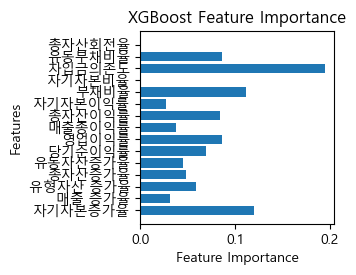

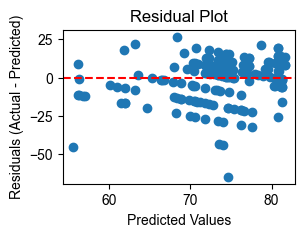

In [62]:
##피처 중요도와 잔차 시각화
plt.rcParams['font.family'] = 'Malgun Gothic'

plt.figure(figsize=(6, 4))
column_names = X_train.columns
plt.figure(figsize=(2.5, 2.5))
feature_importance = model.feature_importances_
plt.barh(column_names, feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance')
plt.show()


# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)
plt.rcParams['font.family'] = 'Arial'
# 잔차 계산 및 시각화
residuals = y_test - y_pred
plt.figure(figsize=(3, 2))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.show()


컴퓨터 프로그래밍 기업의 분류에 따라 보유 기술 가치의 평균을 비교해봅니다.

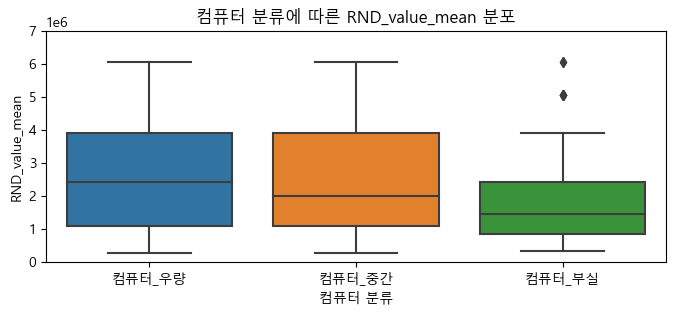

In [64]:
##컴퓨터 분류에 따른 보유 기술 가치 평균의 차이 시각화
mean = comp_RND['RND_value_mean'].mean()
std = comp_RND['RND_value_mean'].std()
threshold = 3  # 이상치를 판단할 때 사용하는 임계값 (일반적으로는 2 이상 또는 3 이상을 사용)

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(8, 3))
sns.boxplot(data=comp_RND, x='컴퓨터_분류', y='RND_value_mean')
plt.xlabel('컴퓨터 분류')
plt.ylabel('RND_value_mean')
plt.ylim(0, 7000000)
plt.title('컴퓨터 분류에 따른 RND_value_mean 분포')
plt.show()